In [1]:
from scipy.optimize import linprog
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import time
from qpsolvers import solve_qp
import cvxpy as cp

In [ ]:
# deprecated
# def get_indx_matrix(m, indices):
#     return np.array([i * m + np.arange(m) for i in indices])

# # c, M, A must be matrices
# def general_basic_solver(c, M, A, d, b, is_coupled=True):
#     # TODO: check
#     n, m = A.shape
#     # TODO: do it somewhere else
#     # convert max to min problem
#     # c = -c
#     c = c.flatten()
    
#     A_ub_sep = np.zeros((n, n * m))
#     sep_indices = get_indx_matrix(m, range(n))
#     A_ub_sep[np.arange(n).reshape(n, 1), sep_indices] = A
    
#     A_ub, b_ub = A_ub_sep, b
#     if is_coupled:
#         A_ub_couple = M.reshape((1, n * m))
#         A_ub = np.concatenate((A_ub_couple, A_ub_sep), axis=0)
#         b_ub = np.zeros(n + 1)
#         b_ub[0] = d
#         b_ub[1:] = b
    
#     res = linprog(c, A_ub, b_ub)
#     argmin_x = res.x
        
#     return argmin_x

# def general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd):
#     # min cx + lambda Mx
#     c_sub = c[sub_indices] + lambd * M[sub_indices]
#     A_sub = A[sub_indices]
#     b_sub = b[sub_indices]
    
#     argmin_x_sub = general_basic_solver(c_sub, M, A_sub, d, b_sub, is_coupled=False)
    
#     return argmin_x_sub

# def general_st_sampling_solver(c, M, A, d, b, num_iter=10, batch_size=1, alpha=1e-3):
#     n, m = M.shape
#     # convert max to min problem
#     c = -c
    
#     # initialize lambda and argmin_x
#     lambd, argmin_x = 0, np.zeros(n * m)
#     M_1d = M.flatten()
#     # cache dot product
#     dot_cache = 0
    
#     # TODO: set seed
#     seed = 42
#     np.random.seed(seed)
    
#     for s in range(num_iter):
#         # TODO: sample with or without rep?
#         sub_indices = np.random.randint(n, size=batch_size)

#         argmin_x_sub = general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd)
        
#         update_indices = get_indx_matrix(m, sub_indices).flatten()
#         # remove old values from cache
#         dot_cache -= np.dot(M_1d[update_indices], argmin_x[update_indices])
#         # update cache
#         argmin_x[update_indices] = argmin_x_sub
#         dot_cache += np.dot(M_1d[update_indices], argmin_x[update_indices])
#         # TODO: update rule
#         lambd += alpha * (dot_cache - d)
# #         print(lambd)
    
#     return argmin_x

In [2]:
# 1d
# def basic_solver(c, M, A, d, b):
#     n = len(c)
#     # convert max to min problem
#     c = -c
    
#     A_ub_couple = M.reshape((1, n))
#     A_ub_sep = np.diag(A)
#     A_ub = np.concatenate((A_ub_couple, A_ub_sep), axis=0)
#     b_ub = np.zeros(n + 1)
#     b_ub[0] = d
#     b_ub[1:] = b
    
#     res = linprog(c, A_ub, b_ub)
#     argmin_x = res.x
        
#     return argmin_x

# def sub_problem_solver(c, M, A, d, b, sub_indices, lambd):
#     # min cx + lambda Mx
#     c_sub = c[sub_indices] + lambd * M[sub_indices]
#     A_ub_sub = np.diag(A[sub_indices])
#     b_ub_sub = b[sub_indices]
    
#     res_sub = linprog(c_sub, A_ub_sub, b_ub_sub)
#     argmin_x_sub = res_sub.x
    
#     return argmin_x_sub

# def st_sampling_solver(c, M, A, d, b, num_iter=10, batch_size=1, alpha=1e-3):
#     n = len(c)
#     # convert max to min problem
#     c = -c
    
#     # initialize lambda and argmin_x
#     lambd, argmin_x = 0, np.zeros(n)
    
#     for s in range(num_iter):
#         # sample with or without rep?
#         sub_indices = np.random.randint(n, size=batch_size)
#         argmin_x_sub = sub_problem_solver(c, M, A, d, b, sub_indices, lambd)
#         argmin_x[sub_indices] = argmin_x_sub
#         lambd += alpha * (np.dot(M, argmin_x) - d)
# #         print(lambd)
    
#     return argmin_x

In [ ]:
# # change num_iter to epoch
# # c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l, lambd~k
# def general_st_sampling_solver(c, M, A, d, b, num_iter=10, batch_size=1, alpha=1e-3, err_list=[], lambd_list=[], is_rep=True):
#     # TODO: check
#     n, k, m = M.shape
#     # convert max to min problem
#     c = -c
    
#     # TODO: keep track of error
#     answer = general_basic_solver(c, M, A, d, b)
    
#     # initialize lambda and argmin_x
#     lambd, argmin_x = np.zeros(k), np.zeros(n * m)
#     # TODO
#     M_2d = np.concatenate(M, axis=1)
#     # cache
#     dot_cache = np.zeros(k)
    
#     # set seed
#     seed = 42
#     np.random.seed(seed)
    
#     # counter
#     counter = 0
#     for s in range(num_iter):
#         # TODO: sample with or without rep?
#         if is_rep:
#             idx = np.random.randint(n, size=n)
#         else:
#             idx = np.random.permutation(n)
#         for j in range(0, n, batch_size):
#             # counter
#             if counter % 10000 == 0:
#                 print("{}/{}".format(counter, num_iter * n / batch_size))
                
#             sub_indices = idx[j: j + batch_size]
            
#             argmin_x_sub = general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd)
        
#             update_indices = get_indx_matrix(m, sub_indices).flatten()
#             # remove old values from cache
#             dot_cache -= np.matmul(M_2d[:, update_indices], argmin_x[update_indices])
#             # update cache
#             argmin_x[update_indices] = argmin_x_sub
#             dot_cache += np.matmul(M_2d[:, update_indices], argmin_x[update_indices])

#             # TODO: update rule
#             lambd += alpha * (dot_cache - d)

#             # TODO: keep track of error and lambd
#             err = np.linalg.norm(argmin_x - answer)
#             err_list.append(err)
#             lambd_list.append(lambd)
#     #         print(lambd)
    
#             # counter
#             counter += 1
    
    
# #     for s in range(num_iter):
# #         # counter
# #         if s % 10000 == 0:
# #             print("{}/{}".format(s, num_iter))
        
# #         # TODO: sample with or without rep?
# #         sub_indices = np.random.randint(n, size=batch_size)

# #         argmin_x_sub = general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd)
        
# #         update_indices = get_indx_matrix(m, sub_indices).flatten()
# #         # remove old values from cache
# #         dot_cache -= np.matmul(M_2d[:, update_indices], argmin_x[update_indices])
# #         # update cache
# #         argmin_x[update_indices] = argmin_x_sub
# #         dot_cache += np.matmul(M_2d[:, update_indices], argmin_x[update_indices])
        
# #         # TODO: update rule
# #         lambd += alpha * (dot_cache - d)
        
# #         # TODO: keep track of error
# #         err = np.linalg.norm(argmin_x - answer)
# #         err_list.append(err)
# # #         print(lambd)
    
#     return argmin_x

In [2]:
def get_all_error_and_time_list(batch_size_list, step_size_list, is_rep, compare_batch, 
                                c, M, A, d, b, epoch_list):
    all_err_list, all_time_hist = [], []
    grid = batch_size_list if compare_batch else step_size_list
    for i in range(len(grid)):
        print(i)
        
        var = grid[i]
        if compare_batch:
            batch_size, alpha = var, step_size_list[0]
        else:
            batch_size, alpha = batch_size_list[0], var
        err_list, time_hist = [], []
        lambd_list = []
#         rs = general_st_sampling_solver(c, M, A, d, b, epoch=epoch_list[i], batch_size=batch_size, alpha=alpha, 
#                                         err_list=err_list, time_hist=time_hist, is_rep=is_rep)
        rs = general_st_sampling_solver(c, M, A, d, b, epoch=epoch_list[i], batch_size=batch_size, alpha=alpha,
                                decay=False, decay_func=sqrt_decay, 
                                augmented=False, rho=.01,
                                ascent_type="full", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, time_hist=time_hist, 
                                is_rep=False)
        # TODO: check
#         all_err_list.append(err_list)
        all_err_list.append(lambd_list)
        all_time_hist.append(time_hist)
    return all_err_list, all_time_hist

def plot_compare_parameter(all_err_list, all_time_hist, batch_size_list, step_size_list, 
                           is_rep, compare_batch, is_time):
    n_plot = len(all_err_list)
    label_list = batch_size_list if compare_batch else step_size_list
    rep_type = "Replacement" if is_rep else "Non-Replacement"
    compare_type = "batch sizes" if compare_batch else "step sizes"
    x_type = "running time" if is_time else "number of iterations"
    
    plt.figure()
    plt.title("{} Error across {}".format(rep_type, compare_type))
    plt.xlabel(x_type)
    plt.ylabel("Error")
    for i in range(n_plot):
        x_axis = all_time_hist[i] if is_time else np.arange(len(all_err_list[i]))
        # TODO: check
        plt.plot(x_axis[-10:], all_err_list[i][-10:], label=str(label_list[i]))
    plt.legend()
    plt.tight_layout()

def plot_once(rep_err_list, rep_time_hist, non_rep_err_list, non_rep_time_hist,
              batch_size, step_size, compare_batch, is_time):
    compare_type = "batch_size" if compare_batch else "step_size"
    x_type = "running time" if is_time else "number of iterations"
    cov = batch_size if compare_batch else step_size
    
    plt.figure()
    plt.title("Replacement/Non-Replacement Error for {} = {}".format(compare_type, cov))
    plt.xlabel(x_type)
    plt.ylabel("Error")
    
    rep_x_axis = rep_time_hist if is_time else np.arange(len(rep_err_list))
    plt.plot(rep_x_axis, rep_err_list, label="Replacement")
    non_rep_x_axis = non_rep_time_hist if is_time else np.arange(len(non_rep_err_list))
    plt.plot(non_rep_x_axis, non_rep_err_list, label="Non-Replacement")
    
    plt.legend()
    plt.tight_layout()
    
def plot_compare_rep(rep_all_err_list, rep_all_time_hist, non_rep_all_err_list, non_rep_all_time_hist,
                     batch_size_list, step_size_list, is_rep, compare_batch, is_time):
    n_plot = len(rep_all_err_list)
    for i in range(n_plot):
        plot_once(rep_all_err_list[i], rep_all_time_hist[i], non_rep_all_err_list[i], non_rep_all_time_hist[i],
                  batch_size_list[min(i, len(batch_size_list) - 1)], 
                  step_size_list[min(i, len(step_size_list) - 1)], 
                  compare_batch, is_time)

In [2]:
def get_indx_matrix(m, indices):
    return np.array([i * m + np.arange(m) for i in indices])

def make_PD(P, x=1e-7):
    diag = x * np.identity(len(P))
    return P + diag
        
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
def general_basic_solver(c, M, A, d, b, is_coupled=True, augmented=False, P=None):
    # TODO: check
    n, l, m = A.shape
    # TODO: do it somewhere else
    # c = -c
    c = c.flatten()

    A_ub_sep = block_diag(*A)

    # TODO: shape of M, d, b, lambd
    b = b.flatten()
    A_ub, b_ub = A_ub_sep, b

    if is_coupled:
        k = M.shape[1]
        A_ub_couple = np.concatenate(M, axis=1)
        A_ub = np.concatenate((A_ub_couple, A_ub_sep), axis=0)
        b_ub = np.zeros(len(d) + len(b))
        b_ub[: len(d)] = d
        b_ub[len(d):] = b

    if augmented:
        # TODO: check
#         P = np.concatenate(P, axis=0)
#         P = block_diag(*P)
#         print(P)
        # TODO: make P PD
        argmin_x = solve_qp(make_PD(P), c, A_ub, b_ub, lb=np.zeros(len(c)))
    else:
        res = linprog(c, A_ub, b_ub)
        # TODO:
        # print(res.status)
#         print(np.linalg.matrix_rank(A_ub), A_ub.shape)
        s_check = res.status
        if s_check != 0:
            print("warning: {}".format(s_check))
        argmin_x = res.x

    return argmin_x

# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l, lambd~k
def general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd, augmented, dot_cache, w, rho=1):
    # TODO: min cj^Txj + lambda^T Mjxj + rho / 2 * ||dot_cache' - d + Mj xj||^2
    # rho / 2 * ||dot_cache - d + Mj xj||^2 = rho / 2 * ||w + Mj xj||^2 = 
    # rho / 2 * (wT + xjkT MjkT)(w + Mjk xjk) ~ rho / 2 * (2wT Mjk xjk + xjkT MjkT Mjk xjk)
    # TODO: concatenate Mj Mk into Mj:k
    # TODO: save M[sub_indices] and M_2d
    c_sub = c[sub_indices] + np.matmul(lambd.T, M[sub_indices])
    A_sub = A[sub_indices]
    b_sub = b[sub_indices]
    
    P_sub = None
    if augmented:
#         w = dot_cache - d
        # TODO: check
        c_sub += rho * np.matmul(w.T, M[sub_indices])
        M_sub_2d = np.concatenate(M[sub_indices], axis=1)
#         P_sub = rho * np.matmul(np.transpose(M[sub_indices], axes=(0,2,1)), M[sub_indices])
        # TODO: check
        P_sub = rho / 2 * np.matmul(M_sub_2d.T, M_sub_2d)

    argmin_x_sub = general_basic_solver(c_sub, M, A_sub, d, b_sub, is_coupled=False, 
                                        augmented=augmented, P=P_sub)

    return argmin_x_sub

# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l, lambd~k
def general_st_sampling_solver(c, M, A, d, b, epoch=10, batch_size=1, alpha=1e-3, 
                               decay=False, decay_func=None, 
                               augmented=False, rho=1, prox_type="IAAL",
                               ascent_type="full", vr_m_order=2,
                               err_list=[], lambd_list=[], time_hist=[], is_rep=True, is_cyc=False,
                               answer=[], tol=1e-10):
    # TODO: check
    n, k, m = M.shape
    # convert max to min problem
    c = -c
    
    # TODO: check
#     c, M, A, d, b = [np.float_(dt) for dt in [c, M, A, d, b]]

    # TODO: keep track of error
    if len(answer) == 0:
        answer = general_basic_solver(c, M, A, d, b)

    # initialize lambda and argmin_x
    lambd, argmin_x = np.zeros(k), np.zeros(n * m)
    # TODO
    M_2d = np.concatenate(M, axis=1)
    # cache
    dot_cache = np.zeros(k)
    
    # TODO: VR
    dot_cache_t_prev = np.zeros(k)
    argmin_x_t_prev = np.zeros(n * m)

    # set seed
    seed = 42
    np.random.seed(seed)

    # counter
    counter = 0
    
    # TODO: keep track of runtime
    start_time = time.time()
    for s in range(epoch):
        # TODO: sample with or without rep?
        if is_rep:
            idx = np.random.randint(n, size=n)
        else:
            idx = np.random.permutation(n)
            
        # TODO: check
        if is_cyc:
            idx = np.arange(n)
            
        # TODO: VR
        if s % vr_m_order == 0:
            dot_cache_t = dot_cache_t_prev
            argmin_x_t = argmin_x_t_prev
            
        for j in range(0, n, batch_size):
            # counter
            if counter % 10000 == 0:
                print("{}/{}".format(counter, epoch * n / batch_size))
            
            sub_indices = idx[j: j + batch_size]
            update_indices = get_indx_matrix(m, sub_indices).flatten()
            
            # TODO: check
            # remove old values from cache
#             print(counter)
#             print(argmin_x)
#             print(dot_cache - d)
#             print("---")
            prev_Mx = np.matmul(M_2d[:, update_indices], argmin_x[update_indices])
            dot_cache -= prev_Mx
    
            # TODO: decay
            decayed_alpha = alpha
#             if s > 230:
#                 decay = True
            if decay:
                decayed_alpha = decay_func(alpha, s)
#                 print(decayed_alpha)

            w = 0
            if prox_type=="IAAL":
                w = dot_cache - d
            elif prox_type=="ADMM":
                w = (dot_cache - d) / n - (n - 1) * prev_Mx / n

            # TODO: check
#             rho = decayed_alpha
#             if s > 200:
#                 rho *= 10
            argmin_x_sub = general_sub_problem_solver(c, M, A, d, b, sub_indices, lambd, 
                                                      augmented,
                                                      dot_cache, 
                                                      # TODO: check,
                                                      w,
                                                      rho=decayed_alpha)

            # update cache
            argmin_x[update_indices] = argmin_x_sub
            # TODO: check
            d_psi = np.matmul(M_2d[:, update_indices], argmin_x[update_indices]) 
            dot_cache += d_psi

            # TODO: check
            # lambd += alpha * (dot_cache - d)
            # TODO: VR
            lambd_prev = lambd
            if ascent_type == "vr":
#                 - batch_size * d / n
                d_psi_t = np.matmul(M_2d[:, update_indices], argmin_x_t[update_indices]) 
#                 - batch_size * d / n
                # TODO: check
                mu_t = batch_size * (dot_cache_t - d) / n
#               lambd = np.maximum(lambd + decayed_alpha * (d_psi), 0)
                lambd = np.maximum(lambd + decayed_alpha * (d_psi - d_psi_t + mu_t), 0)
#               lambd = np.maximum(lambd + decayed_alpha * (dot_cache - d - d_psi_t + mu_t), 0)
            elif ascent_type == "full":
                lambd = np.maximum(lambd + decayed_alpha * (dot_cache - d), 0)
            elif ascent_type == "single":
                lambd = np.maximum(lambd + decayed_alpha * (d_psi - batch_size * d / n), 0)
            
            # TODO: stopping criterion
#             if np.linalg.norm(lambd - lambd_prev) < tol:
#                 print(dot_cache - d)
#                 break
            
            # counter
            counter += 1
            end_time = time.time()
            
        # TODO: inner or outer loop
        # TODO: keep track of runtime
        time_hist.append(end_time - start_time)

        # TODO: keep track of error and lambd
        err = np.linalg.norm(argmin_x - answer) / np.linalg.norm(answer)
        err_list.append(err)
        # TODO: check
        lambd_list.append(lambd)
#          print(lambd)
            
        # TODO: VR
        if s % vr_m_order == 0:
            dot_cache_t_prev = dot_cache
            argmin_x_t_prev = argmin_x

    return argmin_x

def plot_error(err_list, name="Error", required=[]):
    err_list = np.array(err_list)

    plt.figure()
    plt.xlabel('Number of Epochs')
    plt.ylabel(name)
    plt.title(name)
    
    if name == "lambda" and err_list.shape[1] > 1:
        err_list_T = err_list.T
        if required == []:
            required = range(err_list.shape[1])
        for i in required:
            # TODO: check
            plt.plot(err_list_T[i], label=name + str(i))
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        plt.plot(err_list)
    
def log_decay(alpha, k):
    return alpha / (np.log(k + 1) + 1)

def sqrt_decay(alpha, k):
    return alpha / (np.sqrt(k) + 1)

In [3]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
def primal_dual_solver(c, M, A, d, b):
    # TODO: check
    n, l, m = A.shape
    # TODO: do it somewhere else
    # c = -c
    c = c.flatten()

    A_ub_sep = block_diag(*A)
    # TODO: shape of M, d, b, lambd
    b = b.flatten()

    A_ub_couple = np.concatenate(M, axis=1)

    x = cp.Variable(n * m)
    constraints = [A_ub_couple @ x <= d, A_ub_sep @ x <= b, 0 <= x]
    objective = cp.Minimize(cp.sum(c.T @ x))
    prob = cp.Problem(objective, constraints)
    prob.solve()

    print("status:", prob.status)
    print("optimal value", prob.value)
    argmin_x = x.value
    lambda_star = constraints[0].dual_value

    return argmin_x, lambda_star

In [4]:
def sim_data(n, m, k, l, c_bound=10, M_bound=10, A_bound=10, seed=42):
    np.random.seed(seed)
    
    c = np.random.uniform(c_bound, size=(n, m))
    M = np.random.uniform(M_bound, size=(n, k, m))
    # TODO: check bound
    d = np.random.uniform(n * m * M_bound / 4, n * m * M_bound * 3 / 4, size=(k))
    A = np.random.uniform(A_bound, size=(n, l, m))
    b = np.random.uniform(m * A_bound / 4, m * A_bound * 3 / 4, size=(n, l))
    return c, M, A, d, b

In [5]:
def compare_runtime(n_range):
    basic_time_list, st_time_list = [], []
    for n in n_range:
        print(n)
        c = np.array([[2.]] + [[1.] for i in range(n - 1)])
        M = np.array([[[1.]] for i in range(n)])
        A = np.array([[[1.]] for i in range(n)])
        d = np.array([float(n)])
        b = np.array([[float(n)] for i in range(n)])
        
        s_time = time.time()
        argmin_x = general_basic_solver(-c, M, A, d, b)
        e_time = time.time()
        basic_time_list.append(e_time - s_time)
        
        err_list = []
        lambd_list = []
        s_time = time.time()
        rs = general_st_sampling_solver(c, M, A, d, b, epoch=10, batch_size=1, alpha=1e-5,
                                        decay=False, decay_func=sqrt_decay, 
                                        augmented=False, rho=.0002,
                                        ascent_type="vr", vr_m_order=2,
                                        err_list=err_list, lambd_list=lambd_list, is_rep=False, 
                                        answer=argmin_x)
        e_time = time.time()
        st_time_list.append(e_time - s_time)
        plot_error(err_list)
        
    return basic_time_list, st_time_list

def plot_compare_runtime(basic_time_list, st_time_list, n_range):
    plt.figure()
    plt.title("Runtime across Solver")
    plt.xlabel("problem size")
    plt.ylabel("runtime (s)")
    plt.plot(n_range, basic_time_list, label="basic solver")
    plt.plot(n_range, st_time_list, label="st_sampling VR")
    plt.legend()
    plt.tight_layout()

In [ ]:
primal_err_list, lambda_err_list, duality_gap_list, total_time =

In [39]:
n = 100
c = np.array([[2.]] + [[1.] for i in range(n - 1)])
M = np.array([[[1.]] for i in range(n)])
A = np.array([[[1.]] for i in range(n)])
d = np.array([float(n)])
b = np.array([[float(n)] for i in range(n)])

In [65]:
batch_size_list = [1, 5, 10, 20]
step_size_list = [1e-3]
is_rep = False
compare_batch = True
epoch_list = [50, 250, 500, 1000]
all_err_list, all_time_hist = get_all_error_and_time_list(batch_size_list, step_size_list, is_rep, compare_batch, 
                                                          c, M, A, d, b, epoch_list)

0
0/5000.0
1
0/5000.0
2
0/5000.0
3
0/5000.0


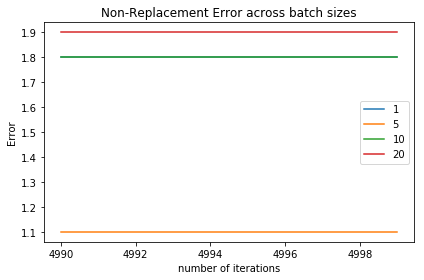

In [66]:
is_time = False
plot_compare_parameter(all_err_list, all_time_hist, batch_size_list, step_size_list, 
                       is_rep, compare_batch, is_time)

1000
0/10000.0


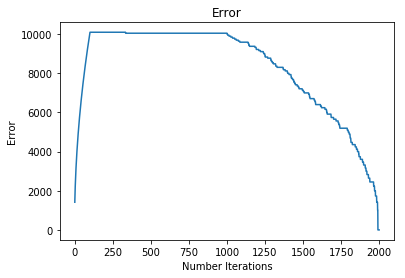

2000
0/20000.0


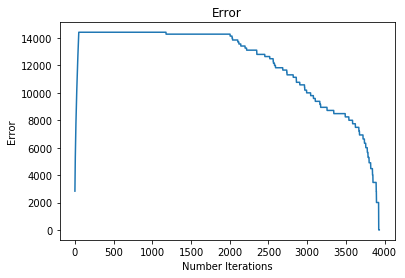

3000
0/30000.0


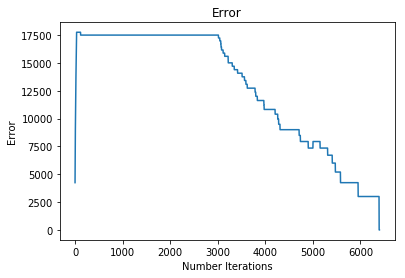

4000
0/40000.0


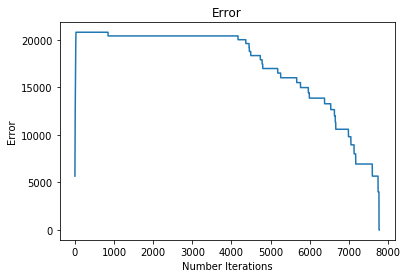

5000
0/50000.0


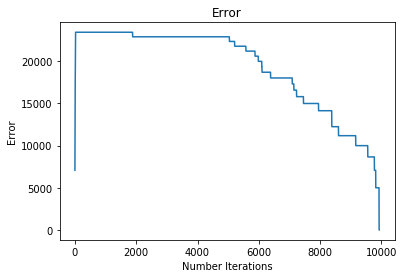

6000
0/60000.0
10000/60000.0


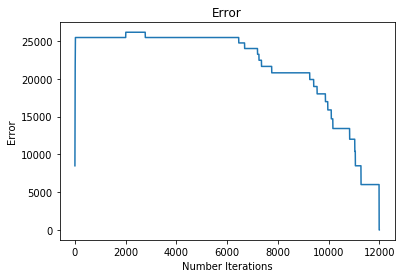

7000
0/70000.0
10000/70000.0


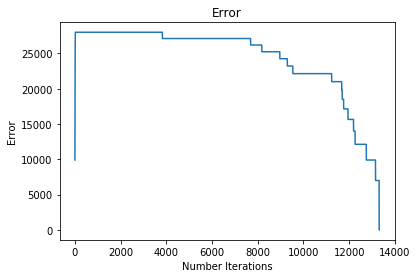

8000
0/80000.0
10000/80000.0


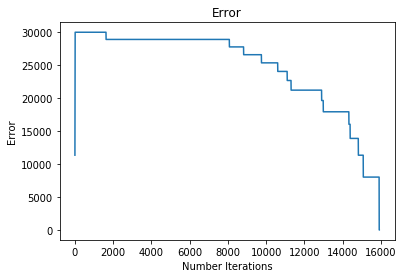

9000
0/90000.0
10000/90000.0


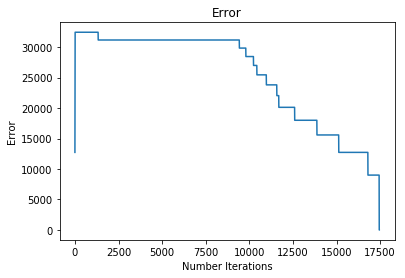

10000
0/100000.0
10000/100000.0


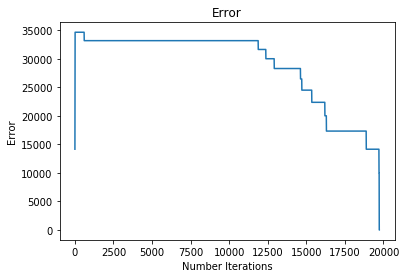

11000
0/110000.0
10000/110000.0
20000/110000.0


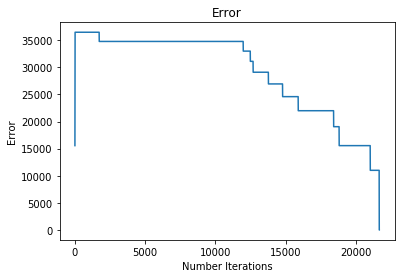

12000
0/120000.0
10000/120000.0
20000/120000.0


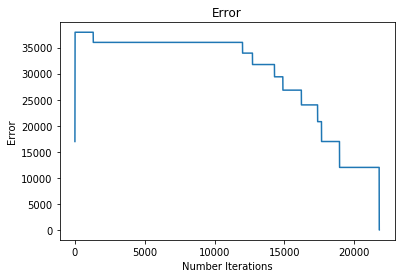

13000
0/130000.0
10000/130000.0
20000/130000.0
30000/130000.0


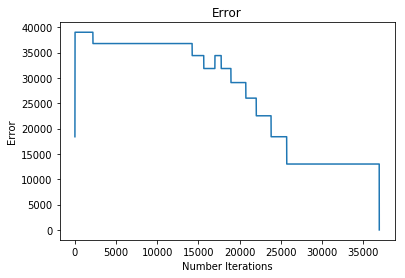

14000
0/140000.0
10000/140000.0
20000/140000.0


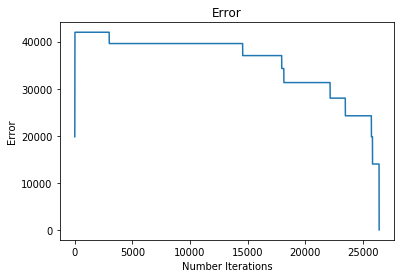

15000
0/150000.0
10000/150000.0
20000/150000.0
30000/150000.0


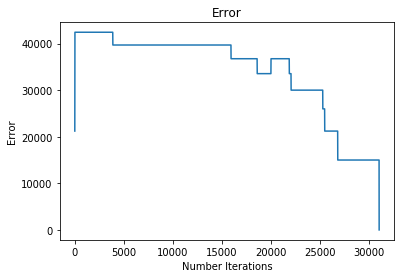

16000
0/160000.0
10000/160000.0
20000/160000.0
30000/160000.0


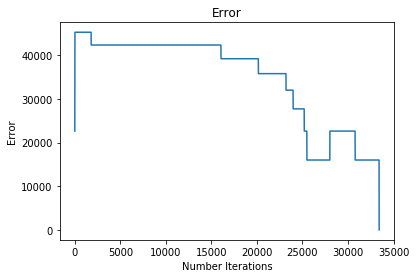

17000
0/170000.0
10000/170000.0
20000/170000.0
30000/170000.0


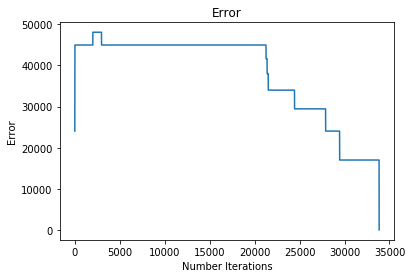

18000
0/180000.0
10000/180000.0
20000/180000.0
30000/180000.0
40000/180000.0


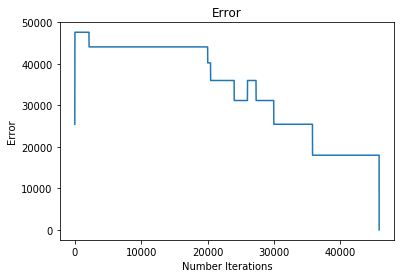

19000
0/190000.0
10000/190000.0
20000/190000.0
30000/190000.0


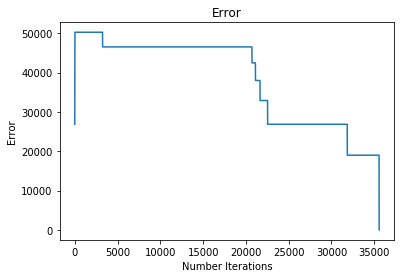

20000
0/200000.0
10000/200000.0
20000/200000.0
30000/200000.0


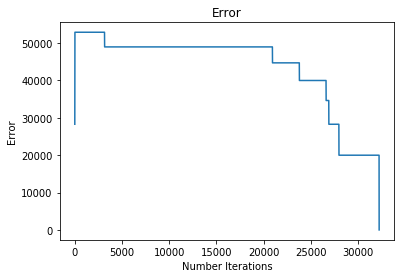

In [49]:
n_range = range(1000, 21000, 1000)
basic_time_list, st_time_list = compare_runtime(n_range)

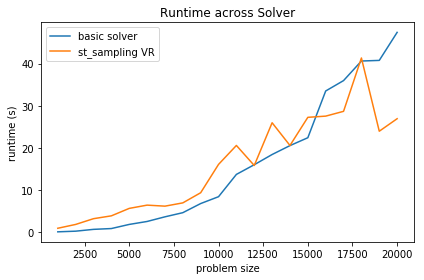

In [57]:
plot_compare_runtime(basic_time_list, st_time_list, n_range)

In [24]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 10
c = np.array([[2.]] + [[1.] for i in range(n - 1)])
M = np.array([[[1.]] for i in range(n)])
A = np.array([[[1.]] for i in range(n)])
d = np.array([float(n)])
b = np.array([[float(n)] for i in range(n)])

s_time = time.time()
argmin_x = general_basic_solver(-c, M, A, d, b)
e_time = time.time()
print(e_time - s_time)

0.010968208312988281


In [25]:
primal_dual_solver(-c, M, A, d, b)

status: optimal
optimal value -19.999999997058215


(array([1.0000000e+01, 3.7999427e-10, 3.7999427e-10, 3.7999427e-10,
        3.7999427e-10, 3.7999427e-10, 3.7999427e-10, 3.7999427e-10,
        3.7999427e-10, 3.7999427e-10]), array([1.66974321]))

0/400.0
0.17684507369995117


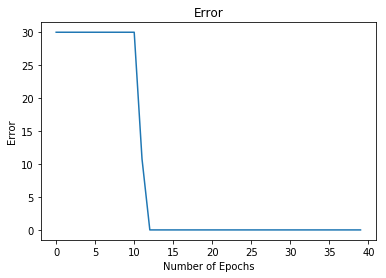

In [12]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=40, batch_size=1, alpha=1e-3,
                                decay=False, decay_func=sqrt_decay, 
                                augmented=True, rho=.00001, prox_type="ADMM",
                                ascent_type="vr", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, is_cyc=False,
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

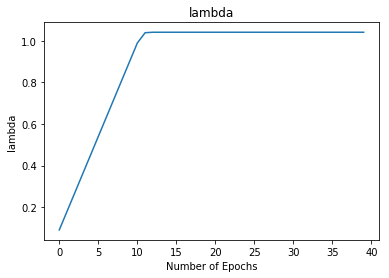

In [13]:
plot_error(lambd_list, name="lambda")

In [14]:
lambd_list[-1]

array([1.04179904])

In [50]:
n, m, k, l = (50, 10, 10, 10)
c, M, A, d, b = sim_data(n, m, k, l, c_bound=10, M_bound=10, A_bound=10, seed=42)
argmin_x = general_basic_solver(-c, M, A, d, b)
argmin_x

array([3.00006166e-07, 9.95334902e-09, 4.31494285e-08, 5.09984109e+00,
       7.60238106e-08, 2.09201174e-08, 3.08852074e+00, 5.31421668e-08,
       1.60110371e-07, 1.99864605e-08, 2.95257584e-08, 8.71002264e-09,
       2.27925015e-08, 1.32026655e-08, 7.17176015e-01, 2.49038480e+00,
       3.59901372e-08, 1.90099958e-08, 1.84986691e-08, 3.44357477e+00,
       4.07025163e-08, 3.18266061e+00, 5.83297376e-08, 1.42699492e-08,
       8.47291296e-09, 6.18653775e-08, 5.33869246e-08, 3.32477792e+00,
       5.71838428e-01, 4.41584733e-08, 3.63205974e-08, 5.14164151e+00,
       1.50794305e-08, 7.15578634e-09, 6.46690687e-09, 9.43552007e-09,
       8.14038152e-08, 2.22544393e+00, 1.00569888e-08, 1.02084007e-08,
       2.73080079e-08, 7.70402322e-08, 4.95200425e+00, 1.38959319e-08,
       2.63725480e-08, 2.75691656e-08, 2.90789455e-07, 2.35703624e-01,
       4.71334405e-08, 1.23805929e+00, 1.21340557e-08, 2.50144011e-08,
       5.52992303e-08, 7.25209474e-09, 1.52167917e-08, 1.34351238e-08,
      

In [51]:
-np.dot(c.flatten(), argmin_x)

-2720.9945190723856

In [52]:
argmin_x1, lambda_star = primal_dual_solver(-c, M, A, d, b)
argmin_x1, lambda_star

status: optimal
optimal value -2720.9945454118983


(array([ 1.38766602e-09, -2.25520654e-11,  1.40332103e-10,  5.09984142e+00,
         3.01612239e-10,  3.27901651e-11,  3.08852105e+00,  1.90959016e-10,
         7.10225167e-10,  2.70371144e-11,  7.48246410e-11, -3.03559697e-11,
         3.97090660e-11, -7.85008377e-12,  7.17176073e-01,  2.49038490e+00,
         1.06685098e-10,  2.09708737e-11,  2.08154293e-11,  3.44357475e+00,
         1.28254911e-10,  3.18266115e+00,  2.16724944e-10, -3.22187102e-12,
        -2.89607612e-11,  2.33508048e-10,  1.90162410e-10,  3.32478062e+00,
         5.71829376e-01,  1.44260115e-10,  1.08115186e-10,  5.14164175e+00,
         3.96601723e-12, -3.54554508e-11, -3.91513986e-11, -2.50360276e-11,
         3.25328614e-10,  2.22544386e+00, -2.07414682e-11, -2.22136166e-11,
         6.53162465e-11,  3.05263668e-10,  4.95200428e+00, -2.96169790e-12,
         6.02464761e-11,  6.45470007e-11,  1.33614240e-09,  2.35703925e-01,
         1.59432566e-10,  1.23805950e+00, -1.17069673e-11,  5.05005190e-11,
         1.9

In [53]:
np.linalg.norm(argmin_x - argmin_x1)

4.607679697762128e-05

In [56]:
M_2d = np.concatenate(M, axis=1)
np.matmul(M_2d, argmin_x) - d

array([-7.49926471e+02,  7.88702550e-06,  2.71693580e-06, -7.17223119e+02,
       -1.45935897e+02,  1.40887005e-06, -5.36858054e+02, -2.53693976e+02,
       -2.39397126e+01, -5.75984704e+02])

In [58]:
np.dot(lambda_star.T, np.matmul(M_2d, argmin_x1) - d)

-4.005829921005796e-09

0/20000.0
10000/20000.0
6.051228761672974


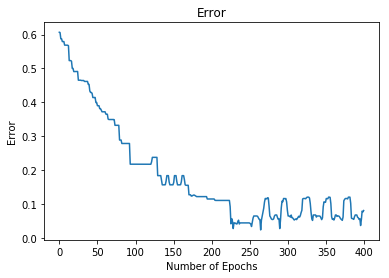

In [61]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=400, batch_size=1, alpha=1e-5,
                                decay=False, decay_func=sqrt_decay, 
                                augmented=True, rho=.00001, prox_type="ADMM",
                                ascent_type="vr", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, is_cyc=False,
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

In [69]:
abs(np.dot(c.flatten(), argmin_x) - np.dot(c.flatten(), rs)) / np.dot(c.flatten(), argmin_x)

0.0012476289350582257

In [62]:
min(err_list)

0.02450625347679856

In [59]:
np.dot(lambda_star.T, np.matmul(M_2d, rs) - d)

-3.3892447664659042

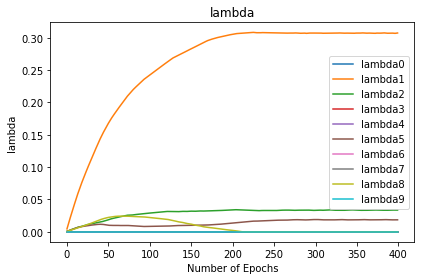

In [47]:
plot_error(lambd_list, name="lambda")

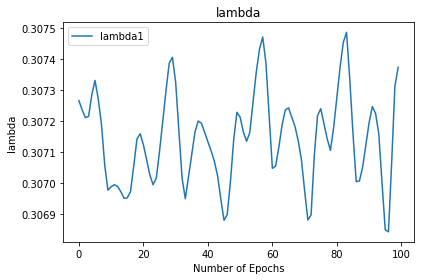

In [48]:
plot_error(lambd_list[-100:], name="lambda", required=[1])

In [49]:
lambd_list[-1]

array([0.        , 0.30737354, 0.03363505, 0.        , 0.        ,
       0.01855496, 0.        , 0.        , 0.        , 0.        ])

In [33]:
n, m, k, l = (100, 10, 10, 10)
c, M, A, d, b = sim_data(n, m, k, l, c_bound=10, M_bound=10, A_bound=10, seed=42)
argmin_x = general_basic_solver(-c, M, A, d, b)
argmin_x

array([2.16291367e+00, 6.16437165e-12, 2.43501822e-11, 2.36937648e-11,
       1.80866111e+00, 1.69122908e+00, 1.34251711e-11, 4.76434107e-12,
       5.08137175e-11, 5.61651663e-12, 5.95035472e+00, 4.31363152e-12,
       6.11293168e-12, 3.91979662e-10, 9.49627223e-11, 9.11190407e-01,
       1.60734019e+00, 8.40753763e-12, 3.25000192e-11, 5.68420015e-11,
       1.08856318e-11, 3.50976604e+00, 6.77167333e-01, 2.60393240e-11,
       1.91816391e-11, 6.31466225e-12, 1.16533691e+00, 6.08093838e-12,
       8.66758066e-01, 9.99222082e-11, 5.59693043e-12, 2.58148809e+00,
       5.25250386e+00, 3.80818581e-12, 1.14362277e-11, 4.79484358e-12,
       9.61467018e-12, 1.17368418e-11, 1.69111914e-11, 3.82603744e-12,
       2.90632287e-11, 7.00604220e-12, 2.59752919e+00, 3.55869863e-12,
       1.79561848e+00, 7.25964587e-12, 1.30477314e+00, 7.51658562e-12,
       1.27510378e-11, 2.71772045e+00, 6.49708331e-12, 5.65618978e-12,
       8.42380488e-12, 4.48378512e-12, 1.20497154e-11, 6.55554520e-12,
      

In [34]:
-np.dot(c.flatten(), argmin_x)

-5121.257564258567

In [35]:
argmin_x1, lambda_star = primal_dual_solver(-c, M, A, d, b)
argmin_x1, lambda_star

status: optimal
optimal value -5121.257564136352


(array([ 2.16291359e+00, -2.10348905e-11,  2.60831746e-10,  2.51256045e-10,
         1.80866120e+00,  1.69122901e+00,  9.04661573e-11, -4.42873639e-11,
         6.71327026e-10, -3.01929298e-11,  5.95035472e+00, -5.62668424e-11,
        -2.30050403e-11,  5.95003519e-09,  1.35135127e-09,  9.11190402e-01,
         1.60734019e+00,  9.24331756e-12,  3.87955869e-10,  7.67403092e-10,
         5.02264941e-11,  3.50976604e+00,  6.77167332e-01,  2.88179104e-10,
         1.81139177e-10, -1.92969138e-11,  1.16533691e+00, -2.41825462e-11,
         8.66758066e-01,  1.43149625e-09, -3.02463002e-11,  2.58148809e+00,
         5.25250386e+00, -5.99975350e-11,  5.35133353e-11, -4.99689931e-11,
         3.11037441e-11,  6.04726744e-11,  1.42980790e-10, -5.84469481e-11,
         3.34107040e-10, -1.21428154e-11,  2.59752920e+00, -6.20342544e-11,
         1.79561846e+00, -5.16423042e-12,  1.30477314e+00, -5.62796612e-12,
         8.15844041e-11,  2.71772046e+00, -1.75148868e-11, -2.98330970e-11,
         1.2

In [36]:
np.linalg.norm(argmin_x - argmin_x1)

4.7296744754181387e-07

In [37]:
M_2d = np.concatenate(M, axis=1)
np.matmul(M_2d, argmin_x) - d

array([-1.90873110e+03,  4.83669282e-09, -1.98419470e+03, -5.98116233e+02,
        5.06815923e-09, -3.94035230e+03, -2.21041200e+03, -3.56267565e+03,
       -2.45701888e+03, -7.32958883e+02])

In [38]:
d

array([5165.15280744, 3189.49410865, 5456.21452875, 4073.92811858,
       2761.74383405, 7243.28078853, 5707.45184532, 6884.59465935,
       5880.28002507, 4284.9184607 ])

0/30000.0
10000/30000.0
20000/30000.0
12.677125930786133


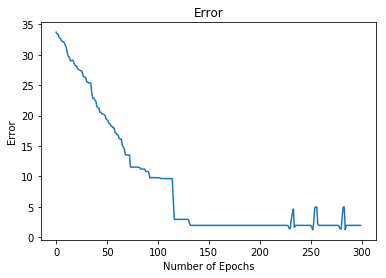

In [39]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=300, batch_size=1, alpha=1e-5,
                                decay=False, decay_func=sqrt_decay, 
                                augmented=True, rho=.00001, prox_type="ADMM",
                                ascent_type="vr", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, is_cyc=False,
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

In [85]:
min(err_list)

1.9221337787323307

In [135]:
min(err_list)

1.1727230514645128

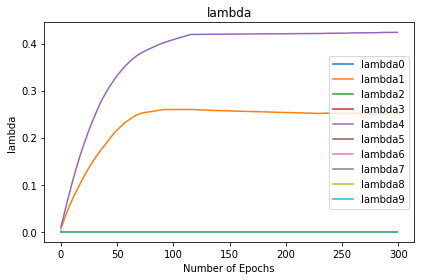

In [40]:
plot_error(lambd_list, name="lambda")

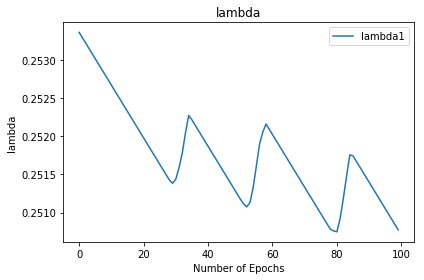

In [137]:
plot_error(lambd_list[-100:], name="lambda", required=[1])

In [41]:
lambd_list[-1]

array([0.        , 0.25077564, 0.        , 0.        , 0.42364936,
       0.        , 0.        , 0.        , 0.        , 0.        ])

0/100000.0
10000/100000.0
20000/100000.0
30000/100000.0
40000/100000.0
50000/100000.0
60000/100000.0
70000/100000.0
80000/100000.0
90000/100000.0
30.228676080703735


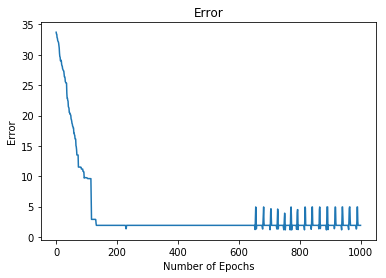

In [150]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=1000, batch_size=1, alpha=1e-5,
                                decay=False, decay_func=sqrt_decay, 
                                augmented=True, rho=.00001, prox_type="ADMM",
                                ascent_type="vr", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, is_cyc=False,
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

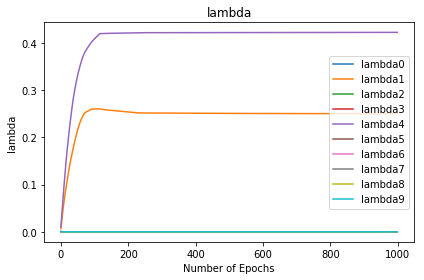

In [151]:
plot_error(lambd_list, name="lambda")

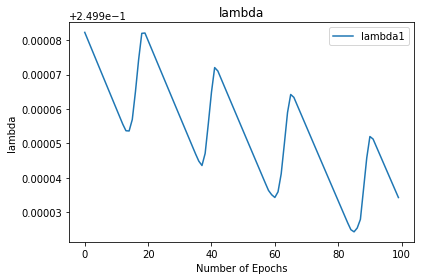

In [152]:
plot_error(lambd_list[-100:], name="lambda", required=[1])

In [4]:
n, m, k, l = (100, 10, 10, 10)
c, M, A, d, b = sim_data(n, m, k, l, c_bound=10, M_bound=10, A_bound=10, seed=42)
argmin_x = general_basic_solver(-c, M, A, d, b)
argmin_x

array([2.16291368, 0.        , 0.        , 0.        , 1.8086611 ,
       1.69122909, 0.        , 0.        , 0.        , 0.        ,
       5.95035472, 0.        , 0.        , 0.        , 0.        ,
       0.91119041, 1.60734019, 0.        , 0.        , 0.        ,
       0.        , 3.50976604, 0.67716733, 0.        , 0.        ,
       0.        , 1.16533691, 0.        , 0.86675807, 0.        ,
       0.        , 2.58148809, 5.25250386, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.59752919, 0.        , 1.79561848,
       0.        , 1.30477315, 0.        , 0.        , 2.71772045,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.43520031, 0.42201078, 0.        , 4.36680432,
       0.        , 3.02797461, 0.        , 0.04105717, 0.        ,
       0.        , 0.        , 0.        , 2.0897063 , 0.        ,
       0.        , 0.        , 5.47756032, 0.        , 0.     

0/10000.0
2.7726540565490723


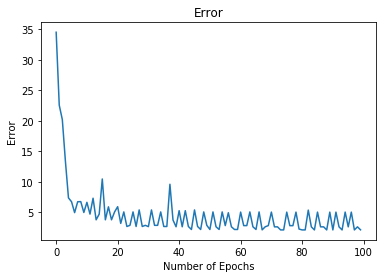

In [8]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=100, batch_size=1, alpha=1e-5,
                                decay=True, decay_func=sqrt_decay, 
                                augmented=True, rho=.00001, prox_type="IAAL",
                                ascent_type="full", vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, is_cyc=False,
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

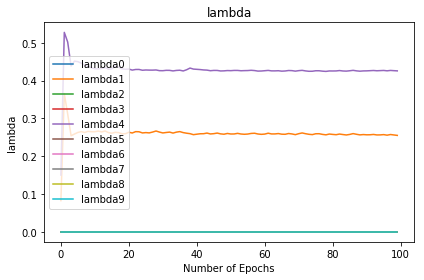

In [9]:
plot_error(lambd_list, name="lambda")

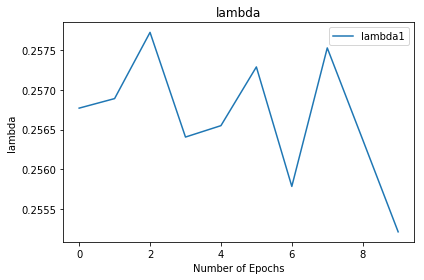

In [10]:
plot_error(lambd_list[-10:], name="lambda", required=[1])

In [21]:
np.array(lambd_list).T[0][-10:]

array([0.60765921, 0.60802822, 0.60792032, 0.60816949, 0.60806131,
       0.60783401, 0.60812784, 0.60820137, 0.60760899, 0.60730446])

In [9]:
argmin_x-rs

array([-4.60742555e-12,  3.06903958e-12,  5.66853607e-15,  0.00000000e+00,
       -2.87325719e-13,  4.32495849e-13, -8.68816130e-12,  0.00000000e+00,
        0.00000000e+00,  7.27595761e-12,  0.00000000e+00,  1.66174559e-12,
        2.48954140e-13,  0.00000000e+00, -2.81996648e-13, -9.19264664e-14,
        6.85673740e-13, -4.54747351e-13, -8.51302213e-14, -7.25537553e-14,
        5.15936942e-01, -4.23309140e-01, -2.82060442e-02, -1.25509556e-13,
       -1.61367152e-17, -2.65577237e-13, -1.13509202e-12,  9.06510056e-14,
       -1.47037937e-12,  2.03859935e-12,  8.26408608e-15,  2.24620322e-12,
       -3.87179178e-12,  0.00000000e+00,  0.00000000e+00, -5.14641364e-13,
       -1.45217172e-13,  6.35841698e-14,  0.00000000e+00,  4.73066031e-13,
        1.52873596e-14,  1.05963559e-13, -1.25122135e-12,  0.00000000e+00,
        2.93542968e-13,  2.34961462e-13, -2.71327405e-12,  5.46307230e-13,
        5.73575973e-12, -3.52606833e-12])

In [64]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 20000
c = np.array([[2.]] + [[1.] for i in range(n - 1)])
M = np.array([[[1.]] for i in range(n)])
A = np.array([[[1.]] for i in range(n)])
d = np.array([float(n)])
b = np.array([[float(n)] for i in range(n)])

s_time = time.time()
argmin_x = general_basic_solver(-c, M, A, d, b)
e_time = time.time()
print(e_time - s_time)

47.29815125465393


0/60000.0
10000/60000.0
20000/60000.0
30000/60000.0
40000/60000.0
[0.]
20.544198989868164


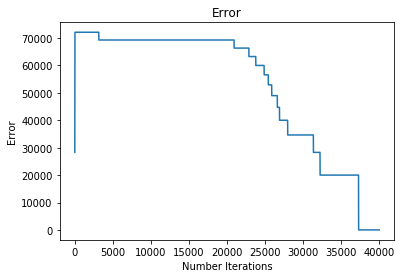

In [65]:
err_list = []
lambd_list = []
s_time = time.time()
rs = general_st_sampling_solver(c, M, A, d, b, epoch=3, batch_size=1, alpha=1e-5,
                                decay=False, decay_func=log_decay, 
                                augmented=False, rho=.007,
                                is_vr=True, vr_m_order=2,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False, 
                                answer=argmin_x)
e_time = time.time()
print(e_time - s_time)
plot_error(err_list)

In [57]:
err_list.index(0)

ValueError: 0 is not in list

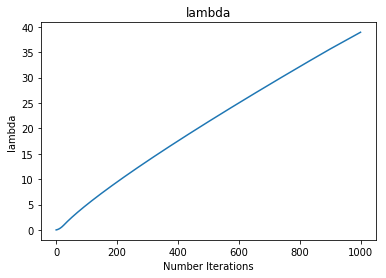

In [61]:
plot_error(lambd_list, name="lambda")

In [9]:
rs

array([10000.,     0.,     0., ...,     0.,     0.,     0.])

In [152]:
lambd = np.array([1, 2])
M = np.array([[[11, 12], [13, 14]], [[21, 22], [23, 24]], [[31, 32], [33, 34]]])
np.matmul(lambd.T, M)

array([[ 37,  40],
       [ 67,  70],
       [ 97, 100]])

In [5]:
n, m, k, l = (10, 5, 5, 5)
c, M, A, d, b = sim_data(n, m, k, l, c_bound=10, M_bound=10, A_bound=10, seed=42)
argmin_x = general_basic_solver(-c, M, A, d, b)
argmin_x

array([2.39444749, 0.        , 0.        , 0.        , 0.55155626,
       0.        , 2.77225452, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 2.4997336 ,
       1.45348218, 3.31441625, 0.        , 0.        , 0.        ,
       0.51593694, 2.08448765, 1.88338331, 0.        , 0.        ,
       0.        , 3.38807853, 0.        , 1.46515748, 0.        ,
       0.        , 0.93452176, 1.50998204, 0.        , 0.        ,
       0.        , 2.80898008, 0.        , 0.        , 0.79541609,
       0.        , 0.        , 1.34553619, 0.        , 1.5230068 ,
       0.        , 0.97988598, 0.        , 0.        , 1.94158869])

In [241]:
M_2d = np.concatenate(M, axis=1)
np.matmul(M_2d, argmin_x) - d

array([-8.94472696, -9.28754187,  0.        ])

0/500.0


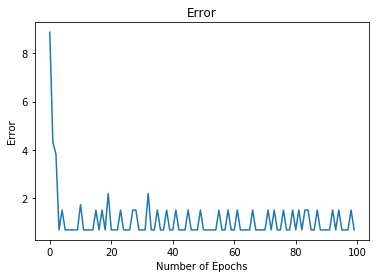

In [6]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=100, batch_size=2, alpha=1e-3,
                                decay=False, decay_func=log_decay, augmented=False, rho=.05,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

In [185]:
err_list[-1]

1.602003358682988

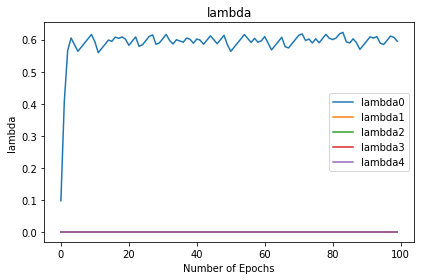

In [7]:
plot_error(lambd_list, name="lambda")

0/500.0


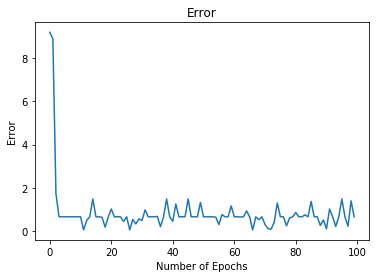

In [12]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=100, batch_size=2, alpha=.0007,
                                decay=False, decay_func=log_decay, augmented=True, rho=.0003,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

In [85]:
err_list[490:]

[1.5617205717763496e-08,
 1.5640780531994223e-08,
 1.3577179320258215e-08,
 2.9551023616230996e-08,
 2.7212348609168084e-08,
 3.138894728566242e-08,
 3.174208412671399e-08,
 3.203106639570271e-08,
 1.8019291799557648e-08,
 1.8718210106842354e-08]

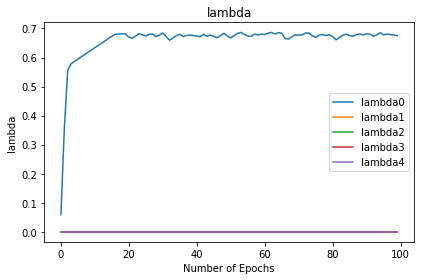

In [11]:
plot_error(lambd_list, name="lambda")

In [14]:
rs

array([ 2.02636747e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.82390773e-12,  6.47843666e-01,  2.57649161e-01,  3.72529030e-09,
        0.00000000e+00,  0.00000000e+00,  1.60527579e-01,  0.00000000e+00,
        0.00000000e+00,  1.21543272e-01,  1.24547951e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.93299762e-02,  0.00000000e+00])

In [54]:
P = np.array([[1.]])
c = np.array([0.])
solve_qp(P, c)

array([-0.])

In [2]:
A = np.array([[[11, 12], [13, 14]], [[21, 22], [23, 24]], [[31, 32], [33, 34]]])
block_diag(*A)

array([[11, 12,  0,  0,  0,  0],
       [13, 14,  0,  0,  0,  0],
       [ 0,  0, 21, 22,  0,  0],
       [ 0,  0, 23, 24,  0,  0],
       [ 0,  0,  0,  0, 31, 32],
       [ 0,  0,  0,  0, 33, 34]])

In [112]:
np.float_(A)

array([[[11., 12.],
        [13., 14.]],

       [[21., 22.],
        [23., 24.]],

       [[31., 32.],
        [33., 34.]]])

In [4]:
np.transpose(A, axes=(0,2,1))

array([[[11, 13],
        [12, 14]],

       [[21, 23],
        [22, 24]],

       [[31, 33],
        [32, 34]]])

In [6]:
np.matmul(A[0].T, A[0])

array([[290, 314],
       [314, 340]])

In [13]:
p = np.matmul(np.transpose(A, axes=(0,2,1)), A)
p

array([[[ 290,  314],
        [ 314,  340]],

       [[ 970, 1014],
        [1014, 1060]],

       [[2050, 2114],
        [2114, 2180]]])

In [15]:
np.concatenate(p, axis=0)

array([[ 290,  314],
       [ 314,  340],
       [ 970, 1014],
       [1014, 1060],
       [2050, 2114],
       [2114, 2180]])

In [21]:
np.concatenate(A, axis=1)

array([[11, 12, 21, 22, 31, 32],
       [13, 14, 23, 24, 33, 34]])

In [388]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 10000
c = np.array([[2.]] + [[1.] for i in range(n - 1)])
M = np.array([[[1.]] for i in range(n)])
A = np.array([[[1.]] for i in range(n)])
d = np.array([float(n)])
b = np.array([[float(n)] for i in range(n)])

0/20000.0
10000/20000.0


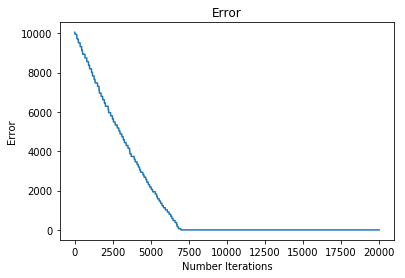

In [389]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=200, batch_size=100, alpha=1e-5,
                                decay=False, decay_func=log_decay, augmented=True, rho=.01,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

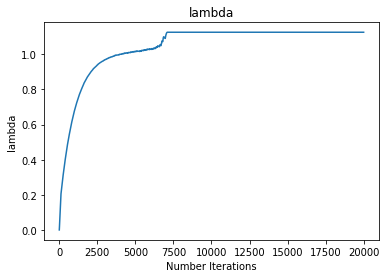

In [390]:
plot_error(lambd_list, name="lambda")

In [13]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 100
c = np.array([[2., 2.]] + [[1., 1.] for i in range(n - 1)])
M = np.array([[[1., 3.], [3., 1.]] for i in range(n)])
A = np.array([[[1., 1.], [1., 1.]] for i in range(n)])
d = np.array([float(n), float(n) / 2])
b = np.array([[float(n), float(n)] for i in range(n)])

In [14]:
c.shape, M.shape, A.shape, d.shape, b.shape

((100, 2), (100, 2, 2), (100, 2, 2), (2,), (100, 2))

In [15]:
general_basic_solver(-c, M, A, d, b)

array([ 6.25, 31.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

0/20000.0
10000/20000.0


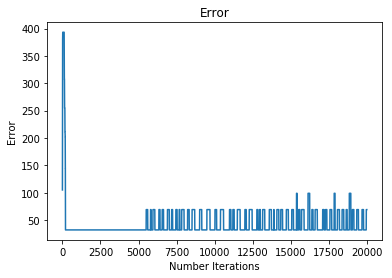

In [16]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=200, batch_size=1, alpha=1e-5,
                                decay=False, decay_func=log_decay, augmented=False,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

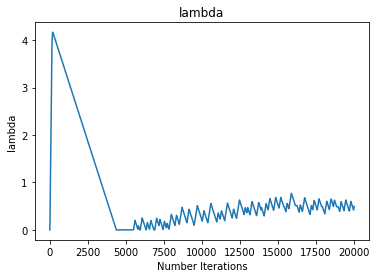

In [17]:
plot_error(lambd_list, name="lambda")

0/2000.0


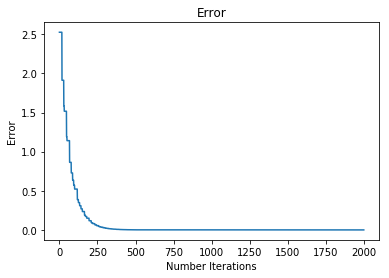

In [18]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=200, batch_size=10, alpha=1e-3,
                                decay=False, decay_func=log_decay, augmented=True, rho=.07,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

In [21]:
err_list[1990:]

[4.326266458913247e-09,
 4.3210503225999844e-09,
 4.72142558666377e-09,
 4.280833846329654e-09,
 4.272653376522027e-09,
 4.683376132084541e-09,
 8.569720246973857e-09,
 8.539789074408805e-09,
 8.539803511565399e-09,
 8.535988577153744e-09]

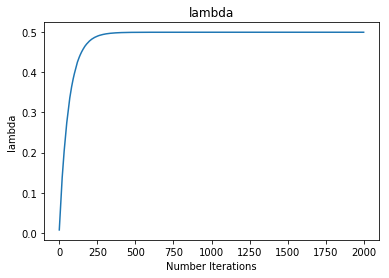

In [19]:
plot_error(lambd_list, name="lambda")

In [20]:
rs

array([ 6.25000001e+00,  3.12500000e+01, -1.32696616e-16,  5.43526068e-13,
       -1.18104571e-10, -6.07649665e-18, -5.43283086e-13,  1.23285609e-17,
       -1.51103621e-10,  1.08705017e-12, -1.36818892e-10, -5.43529988e-13,
       -2.65393233e-16,  1.08705067e-12, -5.37042191e-13,  2.51956712e-13,
        1.32696616e-16,  5.43520026e-13, -4.49212458e-16,  1.63057601e-12,
        2.38415643e-15, -2.00971812e-14, -5.33664455e-13, -1.08705054e-12,
       -2.69734873e-13,  5.32608407e-13, -1.36818892e-10,  0.00000000e+00,
       -4.49212458e-16,  1.63057601e-12, -5.43283086e-13,  1.23285609e-17,
       -1.12553729e-10, -4.78580435e-18,  9.70172197e-11, -5.43523929e-13,
       -2.94670346e-10,  2.05560986e-17, -2.97146921e-10, -5.43585424e-13,
       -1.36818892e-10,  8.97695102e-19, -2.71923286e-13,  1.08705439e-12,
        2.71663068e-13,  5.43522569e-13, -1.36818892e-10,  1.08705096e-12,
        1.63042639e-12, -4.92952054e-18, -1.55696750e-10,  0.00000000e+00,
       -8.15460258e-13, -

In [13]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 100
c = np.array([[2.]] + [[1.] for i in range(n - 1)])
M = np.array([[[1.]] for i in range(n)])
A = np.array([[[1.]] for i in range(n)])
d = np.array([float(n)])
b = np.array([[float(n)] for i in range(n)])

0/10000.0


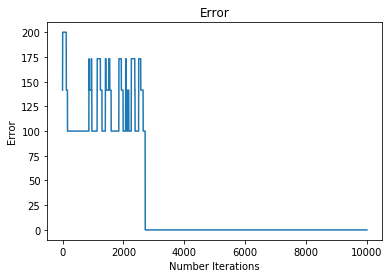

In [16]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=100, batch_size=1, alpha=1e-2,
                                decay=True, decay_func=sqrt_decay, augmented=False,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

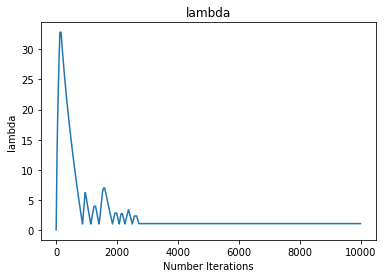

In [17]:
plot_error(lambd_list, name="lambda")

0/2000.0


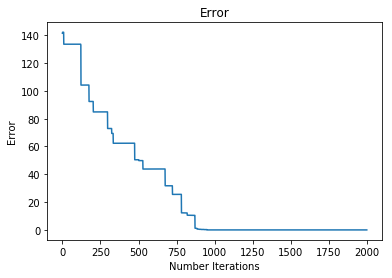

In [42]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=20, batch_size=1, alpha=1e-3,
                                decay=False, decay_func=log_decay, augmented=True, rho=.07,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

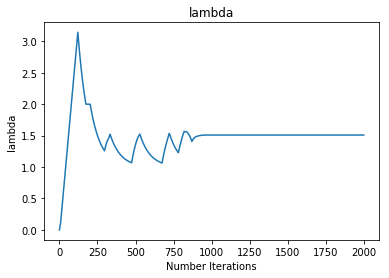

In [43]:
plot_error(lambd_list, name="lambda")

0/2000.0


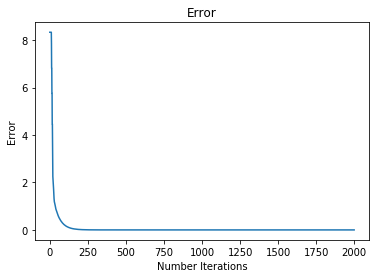

In [47]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=200, batch_size=10, alpha=1e-3,
                                decay=False, decay_func=log_decay, augmented=True, rho=0.04,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

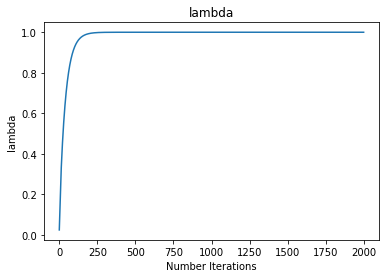

In [48]:
plot_error(lambd_list, name="lambda")

In [49]:
rs

array([ 1.00000000e+02, -2.41720801e-22, -2.41720801e-22, -7.25162354e-22,
        2.41824082e-22, -2.41720792e-22,  7.25162278e-22, -1.57076030e-25,
        0.00000000e+00,  2.41720797e-22,  0.00000000e+00,  8.04067477e-25,
       -6.49274432e-26, -2.41720792e-22,  2.41720797e-22, -7.25162354e-22,
        0.00000000e+00,  2.41720797e-22,  2.41824082e-22,  2.41824082e-22,
       -2.41720792e-22, -7.25162354e-22,  2.41513738e-22, -2.41720792e-22,
        2.41513738e-22, -2.41720792e-22,  0.00000000e+00,  0.00000000e+00,
       -2.41720775e-22, -2.41720801e-22, -2.41720775e-22, -4.83441469e-22,
       -2.41720775e-22,  2.41720797e-22, -2.41720801e-22,  2.41513738e-22,
        2.41720797e-22, -2.41720775e-22,  7.25162278e-22, -7.25162354e-22,
       -2.41720792e-22, -4.83441469e-22,  0.00000000e+00,  2.41824082e-22,
        2.41824082e-22,  0.00000000e+00,  2.41513738e-22,  7.25162278e-22,
       -2.41720792e-22,  7.25162278e-22,  0.00000000e+00, -7.25162354e-22,
        0.00000000e+00,  

0/3000.0


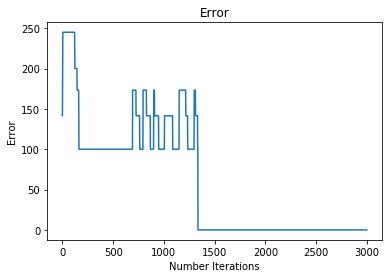

In [31]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=30, batch_size=1, alpha=1e-3, 
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

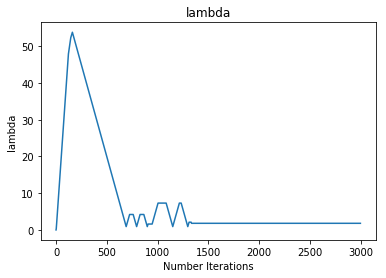

In [32]:
plot_error(lambd_list, name="lambda")

0/3000.0


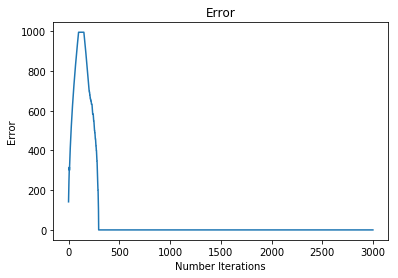

In [65]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=30, batch_size=1, alpha=1e-6, 
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

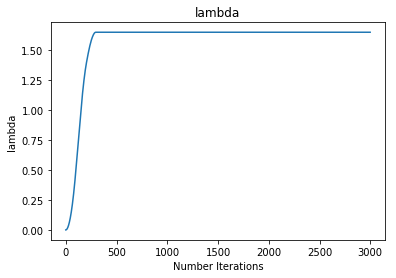

In [66]:
plot_error(lambd_list, name="lambda")

In [49]:
lambd_list[-1]

1.7999999999994878

In [33]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 1000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[[1]] for i in range(n)])
A = np.array([[[1]] for i in range(n)])
d = np.array([n])
b = np.array([[n] for i in range(n)])

In [34]:
# c.shape, M.shape, A.shape, d.shape, b.shape

In [35]:
# general_basic_solver(-c, M, A, d, b)

0/30000.0
10000/30000.0
20000/30000.0


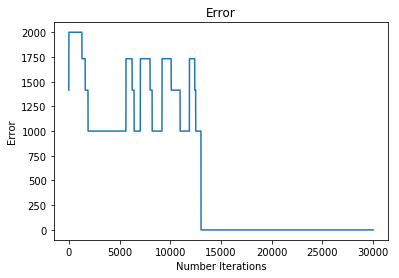

In [47]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=30, batch_size=1, alpha=1e-3,
                                decay=True, decay_func=log_decay,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

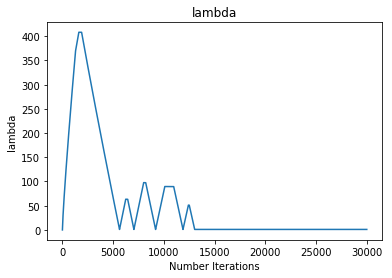

In [48]:
plot_error(lambd_list, name="lambda")

0/30000.0
10000/30000.0
20000/30000.0


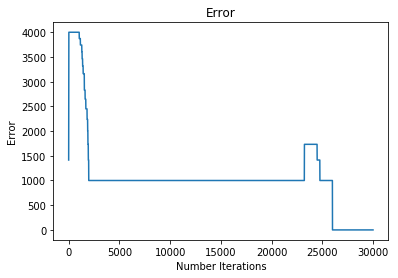

In [45]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=30, batch_size=1, alpha=1e-5, 
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

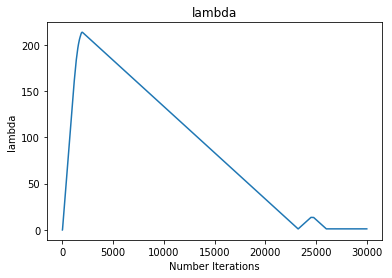

In [46]:
plot_error(lambd_list, name="lambda")

In [44]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=30, batch_size=1, alpha=1e-5, 
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

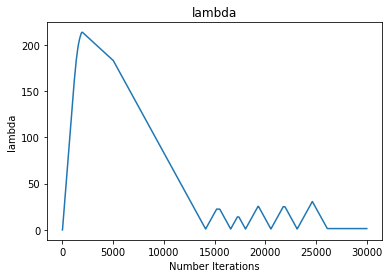

In [77]:
plot_error(lambd_list, name="lambda")

In [43]:
lambd_list[-1]

1.1400000000499504

In [49]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 10000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[[1]] for i in range(n)])
A = np.array([[[1]] for i in range(n)])
d = np.array([n])
b = np.array([[n] for i in range(n)])

0/400000.0
10000/400000.0
20000/400000.0
30000/400000.0
40000/400000.0
50000/400000.0
60000/400000.0
70000/400000.0
80000/400000.0
90000/400000.0
100000/400000.0
110000/400000.0
120000/400000.0
130000/400000.0
140000/400000.0
150000/400000.0
160000/400000.0
170000/400000.0
180000/400000.0
190000/400000.0
200000/400000.0
210000/400000.0
220000/400000.0
230000/400000.0
240000/400000.0
250000/400000.0
260000/400000.0
270000/400000.0
280000/400000.0
290000/400000.0
300000/400000.0
310000/400000.0
320000/400000.0
330000/400000.0
340000/400000.0
350000/400000.0
360000/400000.0
370000/400000.0
380000/400000.0
390000/400000.0


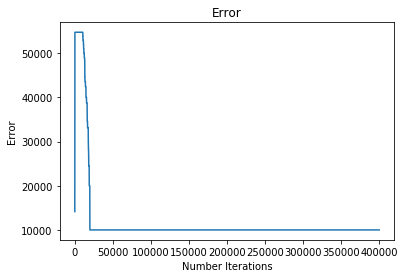

In [60]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=40, batch_size=1, alpha=1e-6,
                                decay=True, decay_func=log_decay,
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

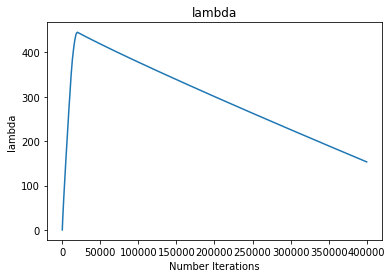

In [62]:
plot_error(lambd_list, name="lambda")

0/400000.0
10000/400000.0
20000/400000.0
30000/400000.0
40000/400000.0
50000/400000.0
60000/400000.0
70000/400000.0
80000/400000.0
90000/400000.0
100000/400000.0
110000/400000.0
120000/400000.0
130000/400000.0
140000/400000.0
150000/400000.0
160000/400000.0
170000/400000.0
180000/400000.0
190000/400000.0
200000/400000.0
210000/400000.0
220000/400000.0
230000/400000.0
240000/400000.0
250000/400000.0
260000/400000.0
270000/400000.0
280000/400000.0
290000/400000.0
300000/400000.0
310000/400000.0
320000/400000.0
330000/400000.0
340000/400000.0
350000/400000.0
360000/400000.0
370000/400000.0
380000/400000.0
390000/400000.0


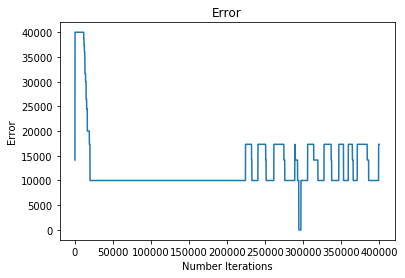

In [37]:
err_list = []
lambd_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=40, batch_size=1, alpha=1e-6, 
                                err_list=err_list, lambd_list=lambd_list, is_rep=False)
plot_error(err_list)

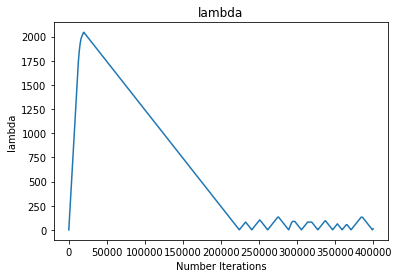

In [39]:
plot_error(lambd_list, name="lambda")

In [63]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 100
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[[1]] for i in range(n)])
A = np.array([[[1]] for i in range(n)])
d = np.array([n])
b = np.array([[n] for i in range(n)])

In [81]:
batch_size_list = [1, 5, 10, 20]
step_size_list = [1e-3, 1e-4, 1e-5]
is_rep = False
compare_batch = True
epoch_list = [20, 100, 200, 400]
# epoch_list = [20, 20, 20, 20]
all_err_list, all_time_hist = get_all_error_and_time_list(batch_size_list, step_size_list, is_rep, compare_batch, 
                                                          c, M, A, d, b, epoch_list)

0
0/2000.0
1
0/2000.0
2
0/2000.0


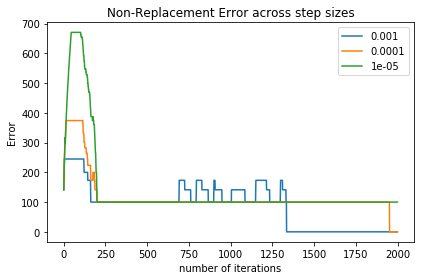

In [83]:
is_time = False
plot_compare_parameter(all_err_list, all_time_hist, batch_size_list, step_size_list, 
                       is_rep, compare_batch, is_time)

In [92]:
batch_size_list = [1, 5, 10, 20]
step_size_list = [1e-3, 1e-4, 1e-5]
compare_batch = True
epoch_list = [20, 100, 200, 400]
# epoch_list = [20, 20, 20, 20]

is_rep=True
rep_all_err_list, rep_all_time_hist = get_all_error_and_time_list(batch_size_list, step_size_list, 
                                                                  is_rep, 
                                                                  compare_batch, 
                                                                  c, M, A, d, b, epoch_list)

0
0/2000.0
1
0/2000.0
2
0/2000.0
3
0/2000.0


In [93]:
is_rep=False
non_rep_all_err_list, non_rep_all_time_hist = get_all_error_and_time_list(batch_size_list, step_size_list, 
                                                                          is_rep, 
                                                                          compare_batch, 
                                                                          c, M, A, d, b, epoch_list)

0
0/2000.0
1
0/2000.0
2
0/2000.0
3
0/2000.0


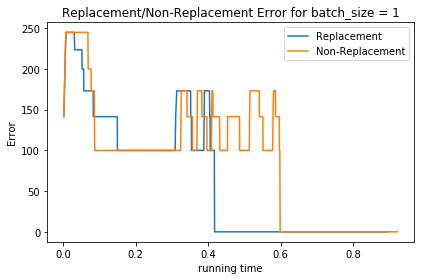

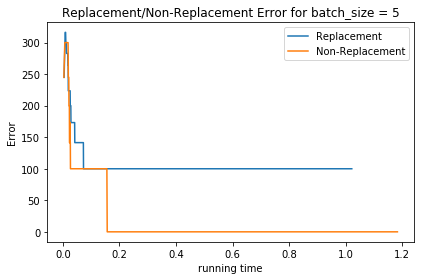

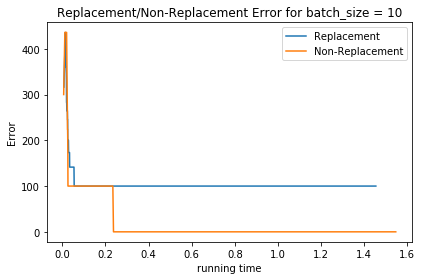

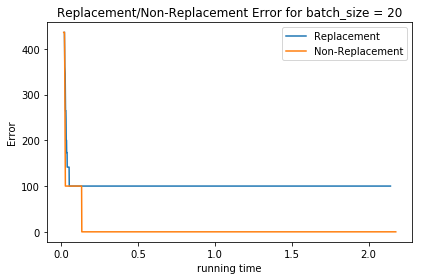

In [96]:
is_time = True
plot_compare_rep(rep_all_err_list, rep_all_time_hist, non_rep_all_err_list, non_rep_all_time_hist,
                 batch_size_list, step_size_list, is_rep, compare_batch, is_time)

0/5000.0


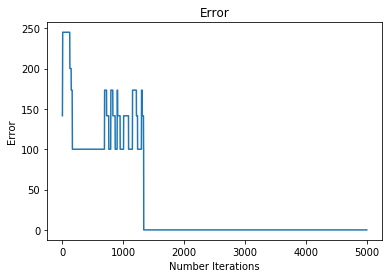

In [53]:
err_list = []
time_hist = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=50, batch_size=1, alpha=1e-3, 
                                err_list=err_list, time_hist=time_hist, is_rep=False)
plot_error(err_list)

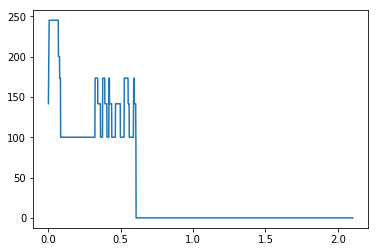

In [54]:
plt.plot(time_hist, err_list)

0/5000.0


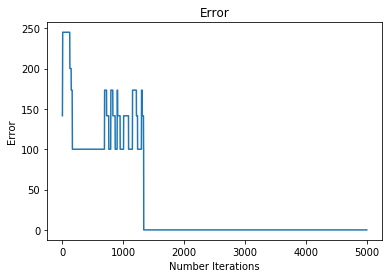

In [39]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=50, batch_size=1, alpha=1e-3, err_list=err_list, is_rep=False)
plot_error(err_list)

0/5000
1000/5000
2000/5000
3000/5000
4000/5000


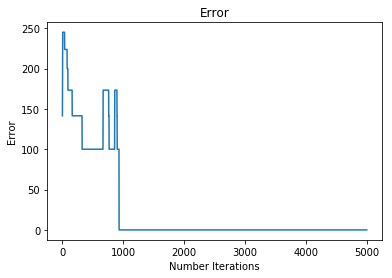

In [173]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=5000, batch_size=1, alpha=1e-3, err_list=err_list)
plot_error(err_list)

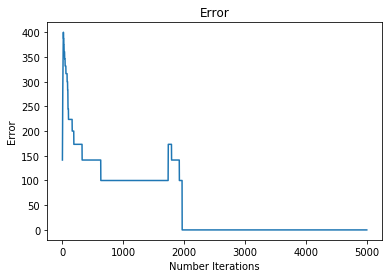

In [168]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=5000, batch_size=1, alpha=1e-4, err_list=err_list)
plot_error(err_list)

In [98]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 10000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[[1]] for i in range(n)])
A = np.array([[[1]] for i in range(n)])
d = np.array([n])
b = np.array([[n] for i in range(n)])

0/200.0


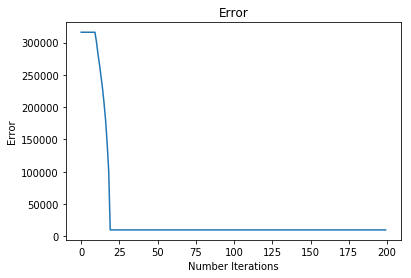

In [101]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, epoch=20, batch_size=1000, alpha=1e-5, err_list=err_list, is_rep=False)
plot_error(err_list)

0/16000
10000/16000


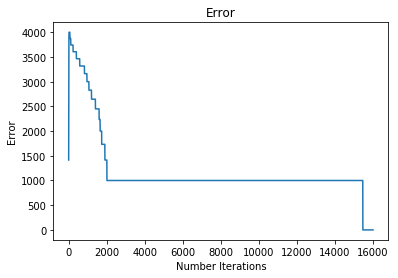

In [196]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=16000, batch_size=1, alpha=1e-5, err_list=err_list)
plot_error(err_list)

0/4000.0


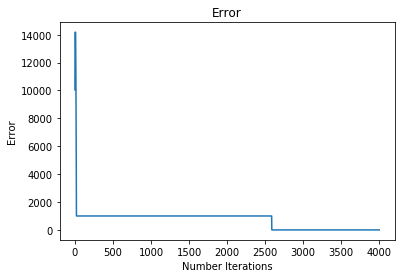

In [229]:
err_list, lambd_list = [], []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=400, batch_size=100, alpha=1e-5, err_list=err_list, lambd_list=lambd_list)
plot_error(err_list)

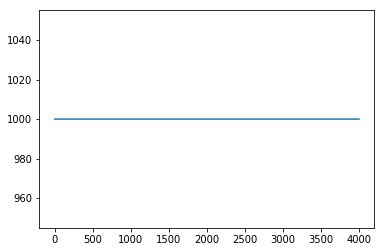

In [230]:
plt.plot(np.array(lambd_list).flatten()) 

0/16000
10000/16000


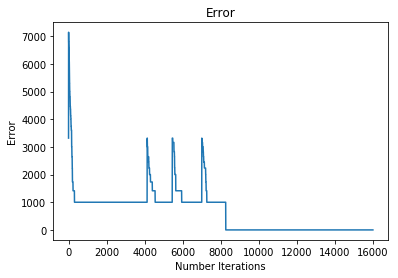

In [195]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=16000, batch_size=10, alpha=1e-5, err_list=err_list)
plot_error(err_list)

0/16000.0
10000/16000.0


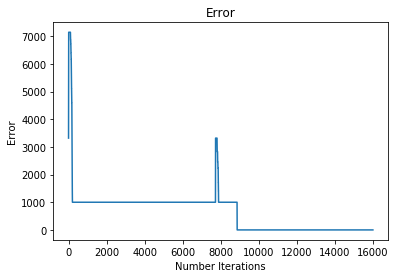

In [210]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=160, batch_size=10, alpha=1e-5, err_list=err_list)
plot_error(err_list)

0/16000
10000/16000


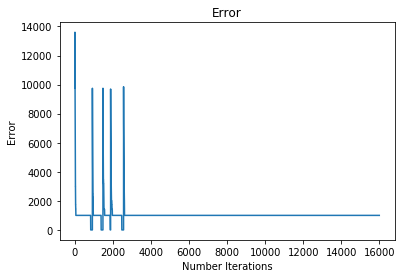

In [197]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=16000, batch_size=100, alpha=1e-5, err_list=err_list)
plot_error(err_list)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

epoch: 761
epoch: 762
epoch: 763
epoch: 764
epoch: 765
epoch: 766
epoch: 767
epoch: 768
epoch: 769
epoch: 770
epoch: 771
epoch: 772
epoch: 773
epoch: 774
epoch: 775
epoch: 776
epoch: 777
epoch: 778
epoch: 779
epoch: 780
epoch: 781
epoch: 782
epoch: 783
epoch: 784
epoch: 785
epoch: 786
epoch: 787
epoch: 788
epoch: 789
epoch: 790
epoch: 791
epoch: 792
epoch: 793
epoch: 794
epoch: 795
epoch: 796
epoch: 797
epoch: 798
epoch: 799
epoch: 800
epoch: 801
epoch: 802
epoch: 803
epoch: 804
epoch: 805
epoch: 806
epoch: 807
epoch: 808
epoch: 809
epoch: 810
epoch: 811
epoch: 812
epoch: 813
epoch: 814
epoch: 815
epoch: 816
epoch: 817
epoch: 818
epoch: 819
epoch: 820
epoch: 821
epoch: 822
epoch: 823
epoch: 824
epoch: 825
epoch: 826
epoch: 827
epoch: 828
epoch: 829
epoch: 830
epoch: 831
epoch: 832
epoch: 833
epoch: 834
epoch: 835
epoch: 836
epoch: 837
epoch: 838
epoch: 839
epoch: 840
epoch: 841
epoch: 842
epoch: 843
epoch: 844
epoch: 845
epoch: 846
epoch: 847
epoch: 848
epoch: 849
epoch: 850
epoch: 851

epoch: 1464
epoch: 1465
epoch: 1466
epoch: 1467
epoch: 1468
epoch: 1469
epoch: 1470
epoch: 1471
epoch: 1472
epoch: 1473
epoch: 1474
epoch: 1475
epoch: 1476
epoch: 1477
epoch: 1478
epoch: 1479
epoch: 1480
epoch: 1481
epoch: 1482
epoch: 1483
epoch: 1484
epoch: 1485
epoch: 1486
epoch: 1487
epoch: 1488
epoch: 1489
epoch: 1490
epoch: 1491
epoch: 1492
epoch: 1493
epoch: 1494
epoch: 1495
epoch: 1496
epoch: 1497
epoch: 1498
epoch: 1499
epoch: 1500
epoch: 1501
epoch: 1502
epoch: 1503
epoch: 1504
epoch: 1505
epoch: 1506
epoch: 1507
epoch: 1508
epoch: 1509
epoch: 1510
epoch: 1511
epoch: 1512
epoch: 1513
epoch: 1514
epoch: 1515
epoch: 1516
epoch: 1517
epoch: 1518
epoch: 1519
epoch: 1520
epoch: 1521
epoch: 1522
epoch: 1523
epoch: 1524
epoch: 1525
epoch: 1526
epoch: 1527
epoch: 1528
epoch: 1529
epoch: 1530
epoch: 1531
epoch: 1532
epoch: 1533
epoch: 1534
epoch: 1535
epoch: 1536
epoch: 1537
epoch: 1538
epoch: 1539
epoch: 1540
epoch: 1541
epoch: 1542
epoch: 1543
epoch: 1544
epoch: 1545
epoch: 1546
epoc

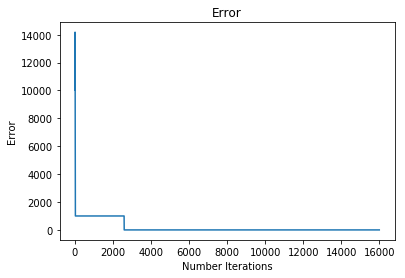

In [204]:
err_list = []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=1600, batch_size=100, alpha=1e-5, err_list=err_list)
plot_error(err_list)

In [212]:
# c~n*m, M~n*k*m, d~k, A~n*l*m, b~n*l
n = 10000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[[1]] for i in range(n)])
A = np.array([[[1]] for i in range(n)])
d = np.array([n])
b = np.array([[n] for i in range(n)])

0/60000.0
10000/60000.0
20000/60000.0
30000/60000.0
40000/60000.0
50000/60000.0


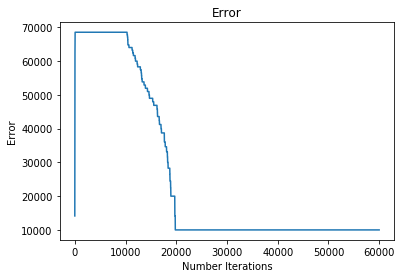

In [213]:
err_list, lambd_list = [], []
rs = general_st_sampling_solver(c, M, A, d, b, num_iter=6, batch_size=1, alpha=1e-7, err_list=err_list, lambd_list=lambd_list)
plot_error(err_list)

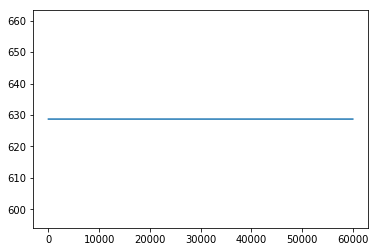

In [215]:
plt.plot(np.array(lambd_list).flatten()) 

In [216]:
lambd_list[:10]

[array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692]),
 array([628.692])]

In [193]:
all(rs==0)

True

In [47]:
n = 2
c = np.array([[2] * n, [1] * n])
M = np.array([[1] * n, [1] * n])
A = np.array([[1] * n, [1] * n])
d = 2 * n
b = np.array([2 * n] * 2)
# general_basic_solver(-c, M, A, d, b)

In [99]:
general_st_sampling_solver(c, M, A, d, b, num_iter=20, batch_size=1, alpha=1e-3)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [68]:
c = np.array([[2], [1]])
M = np.array([[1], [1]])
A = np.array([[1], [1]])
d = 4
b = np.array([4, 4])
general_basic_solver(-c, M, A, d, b)

array([4., 0.])

In [76]:
general_st_sampling_solver(c, M, A, d, b, num_iter=5, batch_size=1, alpha=1e-1)

array([4., 0.])

In [77]:
n = 100
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[1] for i in range(n)])
A = np.array([[1] for i in range(n)])
d = n
b = np.array([n for i in range(n)])
general_basic_solver(-c, M, A, d, b)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [82]:
general_st_sampling_solver(c, M, A, d, b, num_iter=20, batch_size=1, alpha=1e-3)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [96]:
general_st_sampling_solver(c, M, A, d, b, num_iter=30, batch_size=2, alpha=1e-3)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [11]:
c = np.array([2, 1])
M = np.array([1, 1])
A = np.array([1, 1])
d = 4
b = np.array([4, 4])
basic_solver(c, M, A, d, b)

array([4., 0.])

In [12]:
sub_indices = [0]
lambd = 2
sub_problem_solver(-c, M, A, d, b, sub_indices, lambd)

array([0.])

In [13]:
st_sampling_solver(c, M, A, d, b, num_iter=30, batch_size=1, alpha=1e-1)

array([4., 0.])

In [229]:
n = 100
c = np.array([2] + [1 for i in range(n - 1)])
M = np.array([1 for i in range(n)])
A = np.array([1 for i in range(n)])
d = n
b = np.array([n for i in range(n)])
basic_solver(c, M, A, d, b)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [230]:
st_sampling_solver(c, M, A, d, b, num_iter=5000, batch_size=1, alpha=1e-3)

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

In [233]:
n = 10
c = np.array([1] + [1 for i in range(n - 1)])
M = np.array([1 for i in range(n)])
A = np.array([1 for i in range(n)])
d = n
b = np.array([1 for i in range(n)])
basic_solver(c, M, A, d, b)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [236]:
st_sampling_solver(c, M, A, d, b, num_iter=30, batch_size=1, alpha=1e-3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [100]:
# the same as previous example, but with c, M, A reshaped as matrices for the general case
n = 1000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[1] for i in range(n)])
A = np.array([[1] for i in range(n)])
d = n
b = np.array([n for i in range(n)])
general_basic_solver(-c, M, A, d, b)

array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [107]:
general_st_sampling_solver(c, M, A, d, b, num_iter=30, batch_size=1, alpha=1e-5)

array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [110]:
general_st_sampling_solver(c, M, A, d, b, num_iter=20, batch_size=2, alpha=1e-4)

array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [124]:
# the same as previous example, but with c, M, A reshaped as matrices for the general case
n = 5000
c = np.array([[2]] + [[1] for i in range(n - 1)])
M = np.array([[1] for i in range(n)])
A = np.array([[1] for i in range(n)])
d = n
b = np.array([n for i in range(n)])
general_basic_solver(-c, M, A, d, b)

array([5000.,    0.,    0., ...,    0.,    0.,    0.])

In [123]:
general_st_sampling_solver(c, M, A, d, b, num_iter=20, batch_size=1, alpha=1e-8)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59


array([0., 0., 0., ..., 0., 0., 0.])